# Loading the data

In [ ]:
import pandas as pd

In [ ]:
from prophet import Prophet

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/csvs/sales (2).csv'

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/csvs/sales (2).csv')

In [ ]:
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS_,QTR_ID,MONTH_ID,YEAR_ID,DEALSIZE,CUSTOMERNAME,PRODUCTCODE,PRODUCTLINE,MSRP,Unique_ID
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Small,Land of Toys Inc.,S10_1678,Motorcycles,95,1
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Small,Reims Collectables,S10_1678,Motorcycles,95,2
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Medium,Lyon Souveniers,S10_1678,Motorcycles,95,3
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Medium,Toys4GrownUps.com,S10_1678,Motorcycles,95,4
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Medium,Corporate Gift Ideas Co.,S10_1678,Motorcycles,95,5


# Cleaning and setting things up

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ORDERNUMBER      2823 non-null   int64  
 1   QUANTITYORDERED  2823 non-null   int64  
 2   PRICEEACH        2823 non-null   float64
 3   ORDERLINENUMBER  2823 non-null   int64  
 4   SALES            2823 non-null   float64
 5   ORDERDATE        2823 non-null   object 
 6   STATUS_          2823 non-null   object 
 7   QTR_ID           2823 non-null   int64  
 8   MONTH_ID         2823 non-null   int64  
 9   YEAR_ID          2823 non-null   int64  
 10  DEALSIZE         2823 non-null   object 
 11  CUSTOMERNAME     2823 non-null   object 
 12  PRODUCTCODE      2823 non-null   object 
 13  PRODUCTLINE      2823 non-null   object 
 14  MSRP             2823 non-null   int64  
 15  Unique_ID        2823 non-null   int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 353.0+ KB


In [ ]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [ ]:
df.set_index('ORDERDATE', inplace=True)

In [ ]:
df = df[['QUANTITYORDERED']]
df.head(20)

,QUANTITYORDERED
ORDERDATE,
2003-02-24,30
2003-05-07,34
2003-07-01,41
2003-08-25,45
2003-10-10,49
2003-10-28,36
2003-11-11,29
2003-11-18,48
2003-12-01,22


- Re-sampling the data monthly

In [ ]:
df = df.resample('M').sum()

In [ ]:
df = df[['QUANTITYORDERED']]
df.head(20)

,QUANTITYORDERED
ORDERDATE,
2003-01-31,1357
2003-02-28,1449
2003-03-31,1755
2003-04-30,1993
2003-05-31,2017
2003-06-30,1649
2003-07-31,1725
2003-08-31,1974
2003-09-30,2510


In [ ]:
df = df.reset_index('ORDERDATE')

- To be able to fit the data to the Prophet library, we need 2 columns named ds and y since its hardcoded that way in the prophet library

In [ ]:
df = df.rename(columns={'ORDERDATE': 'ds', 'QUANTITYORDERED': 'y'})
df

,ds,y
0,2003-01-31,1357
1,2003-02-28,1449
2,2003-03-31,1755
3,2003-04-30,1993
4,2003-05-31,2017
5,2003-06-30,1649
6,2003-07-31,1725
7,2003-08-31,1974
8,2003-09-30,2510
9,2003-10-31,5515


# Train-Test-Split

In [ ]:
# I have 28 months of sales data.
# I split it into 90-10 for training and testing.

In [ ]:
split_index = int(len(df) * 0.85)

In [ ]:
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

In [ ]:
train_df

,ds,y
0,2003-01-31,1357
1,2003-02-28,1449
2,2003-03-31,1755
3,2003-04-30,1993
4,2003-05-31,2017
5,2003-06-30,1649
6,2003-07-31,1725
7,2003-08-31,1974
8,2003-09-30,2510
9,2003-10-31,5515


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      24 non-null     datetime64[ns]
 1   y       24 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 512.0 bytes


In [ ]:
test_df

,ds,y
24,2005-01-31,3395
25,2005-02-28,3393
26,2005-03-31,3852
27,2005-04-30,2634
28,2005-05-31,4357


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 24 to 28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      5 non-null      datetime64[ns]
 1   y       5 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 212.0 bytes


# Fitting the Model to train set

In [ ]:
m = Prophet(yearly_seasonality=True)
model = m.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3z9qflt/lbemmha5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3z9qflt/pnaxt786.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95189', 'data', 'file=/tmp/tmpi3z9qflt/lbemmha5.json', 'init=/tmp/tmpi3z9qflt/pnaxt786.json', 'output', 'file=/tmp/tmpi3z9qflt/prophet_modeloagjwprg/prophet_model-20240903175012.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:

# Predicting on the test set

In [ ]:
prediction = model.predict(test_df)
predictions = prediction[['ds', 'yhat']]
predictions

,ds,yhat
0,2005-01-31,4141.893983
1,2005-02-28,3945.961195
2,2005-03-31,3312.397600
3,2005-04-30,3451.186971
4,2005-05-31,3804.977770


In [ ]:
test_df

,ds,y
24,2005-01-31,3395
25,2005-02-28,3393
26,2005-03-31,3852
27,2005-04-30,2634
28,2005-05-31,4357


In [ ]:
results = pd.merge(test_df, predictions, on='ds')
results

,ds,y,yhat
0,2005-01-31,3395,4141.893983
1,2005-02-28,3393,3945.961195
2,2005-03-31,3852,3312.397600
3,2005-04-30,2634,3451.186971
4,2005-05-31,4357,3804.977770


In [ ]:
results = results.set_index('ds')

<Axes: xlabel='ds'>

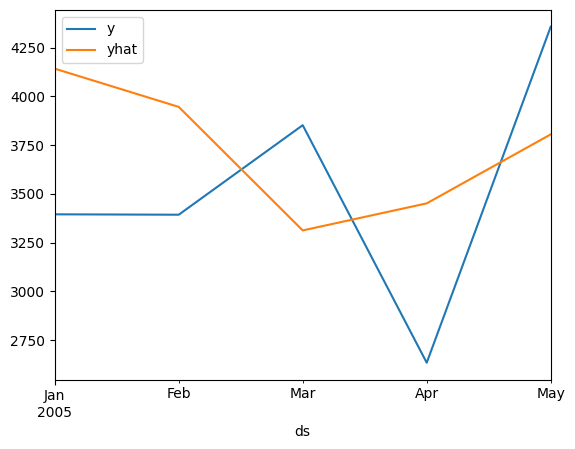

In [ ]:
results.plot()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Calculate MAE
mae = mean_absolute_error(results['y'], results['yhat'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 641.733355785513
Root Mean Squared Error: 652.2745653680336


In [ ]:
results['absolute_percentage_error'] = abs((results['y'] - results['yhat']) / results['y'])

# Calculate the Mean Absolute Percentage Error (MAPE)
mape = results['absolute_percentage_error'].mean() * 100  # Convert to percentage

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 19.20%


# Forecasting the future 12 months values

- Creating the data frame for future

In [ ]:
future = model.make_future_dataframe(periods=12, freq='M')
future

,ds
0,2003-01-31
1,2003-02-28
2,2003-03-31
3,2003-04-30
4,2003-05-31
5,2003-06-30
6,2003-07-31
7,2003-08-31
8,2003-09-30
9,2003-10-31


In [ ]:
end_date = test_df['ds'].max()

In [ ]:
future = pd.DataFrame({
    'ds': pd.date_range(start=end_date, periods=13, freq='M')[1:]  # Forecasting 12 months into the future
})
future

,ds
0,2005-06-30
1,2005-07-31
2,2005-08-31
3,2005-09-30
4,2005-10-31
5,2005-11-30
6,2005-12-31
7,2006-01-31
8,2006-02-28
9,2006-03-31


In [ ]:
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



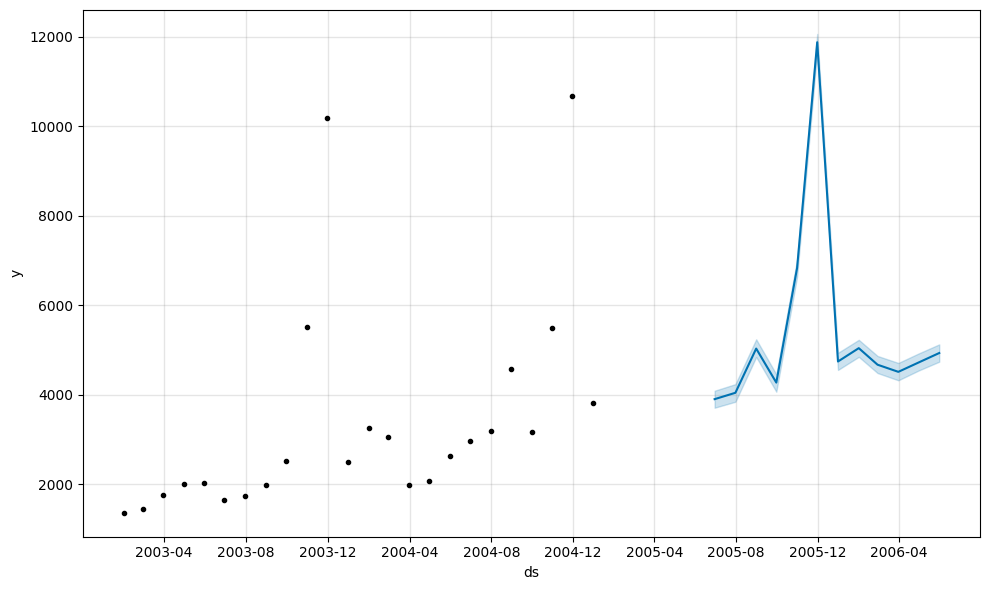

In [ ]:
fig = model.plot(forecast)

# Display the plot
plt.show()

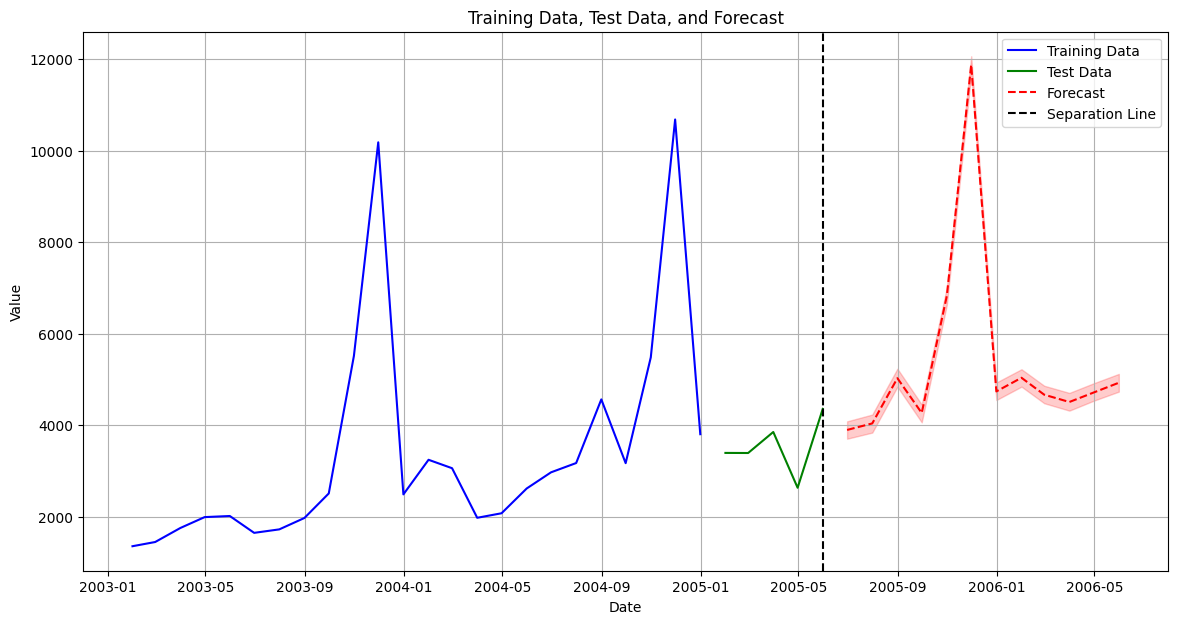

In [ ]:
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='green')

# Plot forecast data
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--')

# Fill the uncertainty intervals
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='red', alpha=0.2)

# Add a vertical line to separate historical and forecast data
plt.axvline(x=end_date, color='black', linestyle='--', label='Separation Line')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Training Data, Test Data, and Forecast')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-06-30,4403.787602,3204.292300,3593.320569,4402.065643,4405.198671,-1007.226847,-1007.226847,-1007.226847,-1007.226847,-1007.226847,-1007.226847,0.0,0.0,0.0,3396.560754
1,2005-07-31,4445.651878,3293.261800,3694.972696,4440.374109,4450.441066,-950.753728,-950.753728,-950.753728,-950.753728,-950.753728,-950.753728,0.0,0.0,0.0,3494.898150
2,2005-08-31,4487.516154,4264.999468,4682.145201,4477.377267,4497.401169,-18.435552,-18.435552,-18.435552,-18.435552,-18.435552,-18.435552,0.0,0.0,0.0,4469.080601
3,2005-09-30,4528.029969,3495.923877,3891.481795,4512.545311,4543.541255,-826.891015,-826.891015,-826.891015,-826.891015,-826.891015,-826.891015,0.0,0.0,0.0,3701.138955
4,2005-10-31,4569.894246,6055.757720,6439.521523,4547.973017,4592.769698,1687.526700,1687.526700,1687.526700,1687.526700,1687.526700,1687.526700,0.0,0.0,0.0,6257.420946
5,2005-11-30,4610.408061,11110.222929,11501.339020,4581.579475,4640.063100,6687.798702,6687.798702,6687.798702,6687.798702,6687.798702,6687.798702,0.0,0.0,0.0,11298.206763
6,2005-12-31,4652.272337,3940.474257,4372.865562,4614.664241,4689.060108,-497.786586,-497.786586,-497.786586,-497.786586,-497.786586,-497.786586,0.0,0.0,0.0,4154.485752
7,2006-01-31,4694.136614,3765.378021,4156.655237,4649.856990,4737.652572,-725.941745,-725.941745,-725.941745,-725.941745,-725.941745,-725.941745,0.0,0.0,0.0,3968.194868
8,2006-02-28,4731.949508,3518.638209,3933.776625,4678.295059,4785.168025,-1007.004446,-1007.004446,-1007.004446,-1007.004446,-1007.004446,-1007.004446,0.0,0.0,0.0,3724.945062
9,2006-03-31,4773.813784,3400.192572,3787.989162,4711.819614,4837.989029,-1175.960427,-1175.960427,-1175.960427,-1175.960427,-1175.960427,-1175.960427,0.0,0.0,0.0,3597.853357


In [ ]:
forecast_df = forecast.copy()

In [ ]:
forecast_df = forecast_df[['ds', 'yhat']]
forecast_df

,ds,yhat
0,2005-06-30,3396.560754
1,2005-07-31,3494.898150
2,2005-08-31,4469.080601
3,2005-09-30,3701.138955
4,2005-10-31,6257.420946
5,2005-11-30,11298.206763
6,2005-12-31,4154.485752
7,2006-01-31,3968.194868
8,2006-02-28,3724.945062
9,2006-03-31,3597.853357


In [ ]:
forecast_df = forecast_df.rename(columns={'yhat': 'y'})

In [ ]:
forecast_df

,ds,y
0,2005-06-30,3396.560754
1,2005-07-31,3494.898150
2,2005-08-31,4469.080601
3,2005-09-30,3701.138955
4,2005-10-31,6257.420946
5,2005-11-30,11298.206763
6,2005-12-31,4154.485752
7,2006-01-31,3968.194868
8,2006-02-28,3724.945062
9,2006-03-31,3597.853357


In [ ]:
forecast_df['y'] = forecast_df['y'].astype(int)

In [ ]:
df

,ds,y
0,2003-01-31,1357
1,2003-02-28,1449
2,2003-03-31,1755
3,2003-04-30,1993
4,2003-05-31,2017
5,2003-06-30,1649
6,2003-07-31,1725
7,2003-08-31,1974
8,2003-09-30,2510
9,2003-10-31,5515


In [ ]:
combined_df = pd.concat([df, forecast_df], axis=0)
combined_df

,ds,y
0,2003-01-31,1357
1,2003-02-28,1449
2,2003-03-31,1755
3,2003-04-30,1993
4,2003-05-31,2017
5,2003-06-30,1649
6,2003-07-31,1725
7,2003-08-31,1974
8,2003-09-30,2510
9,2003-10-31,5515


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression

In [ ]:
fig = make_subplots()

# Add historical data trace
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Historical Data',
                         line=dict(color='royalblue', width=2)))

# Add forecast data trace
fig.add_trace(go.Scatter(x=forecast_df['ds'], y=forecast_df['y'], mode='lines', name='Forecast',
                         line=dict(color='firebrick', width=2)))

# Add vertical line to separate historical and forecast data
separation_date = df['ds'].max()  # Date where historical data ends
fig.add_shape(type='line',
               x0=separation_date, x1=separation_date,
               y0=forecast_df['y'].min(), y1=forecast_df['y'].max(),
               line=dict(color='black', width=2),
               name='Separation Line')

# Update layout
fig.update_layout(
    title='Historical Data and Forecast',
    xaxis_title='Date',
    yaxis_title='Quantity Sold',
    legend_title='Legend',
    template='plotly_white',  # Clean and simple template
    margin=dict(l=40, r=40, t=40, b=40),  # Adjust margins for better layout
    shapes=[dict(
        type='line',
        x0=separation_date, x1=separation_date,
        y0=forecast_df['y'].min(), y1=forecast_df['y'].max(),
        line=dict(color='black', width=1.5),
        name='Separation Line'
    )]
)

# Show the interactive plot
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
combined_df

,ds,y
0,2003-01-31,1357
1,2003-02-28,1449
2,2003-03-31,1755
3,2003-04-30,1993
4,2003-05-31,2017
5,2003-06-30,1649
6,2003-07-31,1725
7,2003-08-31,1974
8,2003-09-30,2510
9,2003-10-31,5515


In [ ]:
# full_sales_forecast = combined_df.copy()

- The prophet model is better able to trace the seasonality from the data and gave better forecasts.
- However, it did not perform well when predicting on the test set which might also be because of a very small test set.
- For the further analysis and steps, I will proceed with this model and forecast for the 7 product categories.